In [1]:
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. Introduction to Data Structures
### 1.1. Theory
Now that you've had some real experience using `spaCy's` objects, it's time for you to learn more about what's actually going on under `spaCy's` hood.

In this section, we'll take a look at the shared vocabulary and how spaCy deals with strings.
#### Shared vocab and string store
`spaCy` stores all shared data in a vocabulary, the `Vocab`. 

This includes words, but also the labels schemes for tags and entities.

To save memory, all strings are encoded to `hash IDs`. If a word occurs more than once, we don't need to save it every time. Instead, `spaCy` uses a hash function to generate an ID and stores the string only once in the string store. 

The `string` store is available as `nlp.vocab.strings`. 

In [2]:
# Import the English language class
from spacy.lang.en import English

# create the NLP-object
nlp = English()
coffee_hash = nlp.vocab.strings['coffee']
coffee_hash

3197928453018144401

It's a lookup table that works in both directions. You can look up a string and get its hash, and look up a hash to get its string value. Internally, spaCy only communicates in hash `IDs`. 

**Hash IDs can't be reversed, though.**

In [3]:
coffee_strings = nlp.vocab.strings[coffee_hash]
coffee_strings

'coffee'

If a word in not in the vocabulary, there's no way to get its string. That's why we always need to pass around the shared vocab.

- To get the hash for a string, we can look it up in `nlp.vocab.strings`. 
- To get the string representation of a hash, we can look up the hash.

In [4]:
doc = nlp("I love coffee")
print("hash-value: \t", nlp.vocab.strings['coffee'])
print("string-value: \t", nlp.vocab.strings[3197928453018144401])

hash-value: 	 3197928453018144401
string-value: 	 coffee


- A `Doc` object also exposes its vocab and strings.

In [5]:
print("hash-value (with doc.): \t", doc.vocab.strings["coffee"])

hash-value (with doc.): 	 3197928453018144401


#### Lexemes: entries in the vocabulary
`Lexemes` are `context-independent entries` in the `vocabulary`. You can get a lexeme by looking up a string or a hash `ID` in the `vocab`. 

In [6]:
lexeme = nlp.vocab['coffee']

# print the lexical-attribute
print('{:<10}{:<30}{:<20}'.format(lexeme.text, lexeme.orth, lexeme.is_alpha))

coffee    3197928453018144401           1                   


Lexemes expose attributes, just like tokens. 

They hold context-independent information about a word, like the `text` (with `.text` attribute), the hash (`.orth`), or whether the the word consists of `alphanumeric characters` (with `.is_alpha`). 

**Lexemes don't have part-of-speech `tags`**, dependencies or entity labels. Those depend on the context.
#### Vocab, hashes and lexemes
Here's an example. The Doc contains words in context – in this case, the tokens `"I"`, `"love"` and `"coffee"` with their part-of-speech tags and dependencies. Each token refers to a lexeme, which knows the word's hash ID. 

To get the string representation of the word, spaCy looks up the hash in the string store.

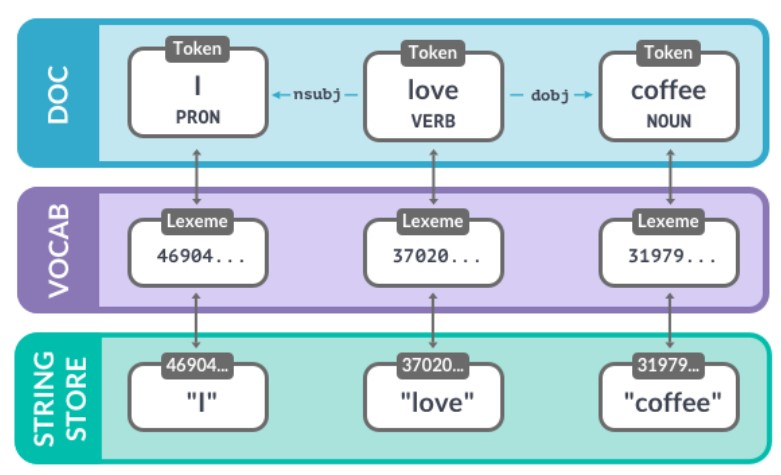

In [7]:
from IPython.display import Image
## Hình minh họa Image(fig1, height, width)

### 1.2. PRACTICES
#### Exercise 1.2.1. Strings to hashes
The `nlp` object has already been created for you.

**Step 1.**
>- Look up the string `"cat"` in `nlp.vocab.strings` to get the hash.
>- Look up the hash to get back the string.

In [8]:
# Look up the hash for the word "cat"
cat_hash = nlp.vocab.strings["cat"]
print(cat_hash)

# Look up the cat_hash to get the string
cat_string = nlp.vocab.strings[cat_hash]
print(cat_string)

5439657043933447811
cat


**Step 2.**
>- Look up the string label `"PERSON"` in `nlp.vocab.strings` to get the hash.
>- Look up the hash to get back the string.


In [9]:
# Look up the hash for the string label "PERSON"
person_hash = nlp.vocab.strings["PERSON"]
print(person_hash)

# Look up the person_hash to get the string
person_string = nlp.vocab.strings[person_hash]
print(person_string)

380
PERSON


#### Exercise 1.2.2. Vocab, hashes and lexemes
Why does this code throw an error?

            from spacy.lang.en import English
            from spacy.lang.de import German

            # Create an English and German nlp object
            nlp = English()
            nlp_de = German()
            # Get the ID for the string 'Bowie'
            bowie_id = nlp.vocab.strings['Bowie']
            print(bowie_id)

            # Look up the ID for 'Bowie' in the vocab
            print(nlp_de.vocab.strings[bowie_id])

#### Answers.
Look at the following error, 

            Traceback (most recent call last):
              File "<stdin>", line 12, in <module>
                print(nlp_de.vocab.strings[bowie_id])
              File "<stdin>", line 138, in spacy.strings.StringStore.__getitem__
            KeyError: "[E018] Can't retrieve string for hash '2644858412616767388'."
            
Hence, **The string 'Bowie' isn't present in the German vocab, so the hash can't be resolved in the string store.**            

In the other words, `Hashes` can't be reversed. 

`=> To prevent this problem`, add the word to the new vocab by processing a text or looking up the string, or use the same vocab to resolve the hash back to a string.

## 2. Data Structures
### 2.1. Theory.
Now that you know all about the vocabulary and string store, we can take a look at the **most important data structure**: 
- `the Doc`, and 
- its views `Token` and `Span`.
#### The Doc object
The `Doc` is one of the central data structures in `spaCy`. 

It's created automatically when you process a text with the `nlp` object. 

But you can also instantiate the class manually. After creating the `nlp object`, we can import the `Doc class` from `spacy.tokens`. 

Here we're creating a `Doc` from three words.

In [10]:
from spacy.tokens import Doc
words = ["Hello", "words", "!"]

The spaces are a list of boolean values indicating whether the word is followed by a `space`. 

In [11]:
spaces = [True, False, False]

Every token includes that information – even the last one! 

The `Doc` class takes three `arguments`: the `shared vocab`, the `words` and the `spaces`.

In [12]:
# create a doc manually
doc = Doc(nlp.vocab, words = words, spaces = spaces)
doc

Hello words!

#### The Span object 
A `Span` is a slice of a `Doc` consisting of one or more tokens. 

The `Span` takes at least three arguments: 
- the `doc` it refers to, and 
- the `start` and 
- `end` index of the `span`. 

Remember that the end index is exclusive!

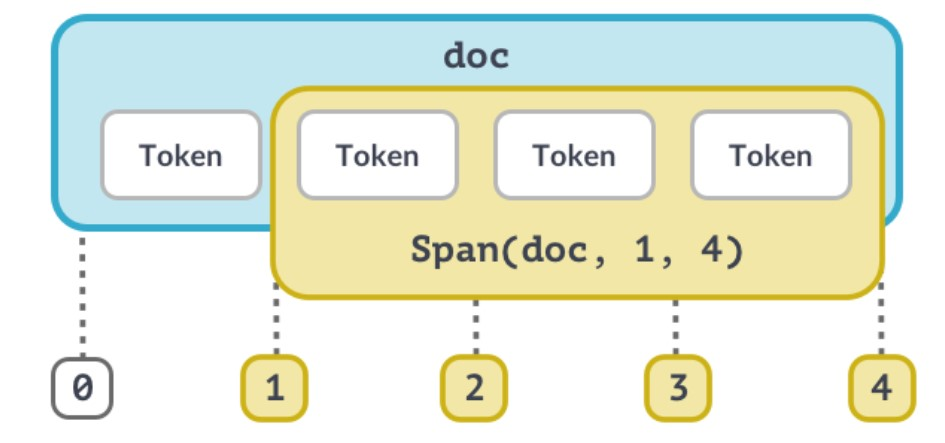

In [13]:
## Hình minh họa Image(fig1, height, width)

To create a Span manually, we can also import the class from `spacy.tokens`. 


In [14]:
from spacy.tokens import Span

We can then instantiate it with the doc and the span's start and end index. 

In [15]:
span = Span(doc, 0, 2)
span

Hello words

To add an entity `label` to the span, we first need to look up the string in the string store.

In [16]:
span_with_label = Span(doc, 0, 2, label = "GREETING")
span_with_label

Hello words

We can then provide it to the span as the label argument. The `doc.ents` are writable, so we can add entities manually by overwriting it with a list of spans.

In [17]:
# add span to the doc.ents
doc.ents = [span_with_label]

#### Best practices
A few tips and tricks before we get started: 
- The `Doc` and `Span` are very **powerful** and **optimized for performance**. They give you access to all references and **relationships of the words and sentences**. - If your application needs to output strings, make sure to convert the doc as **late as possible**. 
- If you do **it too early**, you'll **lose all relationships between the tokens**. 
- To keep things **consistent**, try to use built-in token attributes wherever possible. 

For example, `token.i` for the token `index`. Also, don't forget to always pass in the shared vocab!

### 2.2. PRACTICES
#### Exercise 2.2.1. Creating a Doc
Let's create some Doc objects from scratch! The nlp object has already been created for you.

By the way, if you haven't downloaded it already, check out the spaCy Cheat Sheet. It includes an overview of the most important concepts and methods and might come in handy if you ever need a quick refresher!
#### SOLUTION.

In [18]:
# Import the Doc class
from spacy.tokens import Doc 

""" Step 1. """
# Desired text: "spaCy is cool!"
words = ['spaCy', 'is', 'cool', '!']
spaces = [True, True, False, False]

# Create a Doc from the words and spaces
doc = Doc(nlp.vocab, words=words, spaces=spaces)
print(doc.text)
print(25*'=-')
""" Step 2. """
# Desired text: "Go, get started!"
words = ['Go', ',', 'get', 'started', '!']
spaces = [False, True, True, False, False]

# Create a Doc from the words and spaces
doc = Doc(nlp.vocab, words = words, spaces = spaces)
print(doc.text)
print(25*'=-')

""" Step 3. """
# Desired text: "Oh, really?!"
words = ['Oh', ',', 'really', '?', '!']
spaces = [False, True, False, False, False]

# Create a Doc from the words and spaces
doc = Doc(nlp.vocab, words = words, spaces = spaces)
print(doc.text)

spaCy is cool!
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Go, get started!
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Oh, really?!


#### Exercise 2.2.2.  Docs, spans and entities from scratch
In this exercise, you'll create the Doc and Span objects manually, and update the named entities – just like spaCy does behind the scenes. A shared nlp object has already been created.
#### SOLUTION.
**Step 1.**
>- Import the `Doc` and `Span` classes from `spacy.tokens`.
>- Use the `Doc` class directly to create a doc from the words and spaces.

In [19]:
# Import the Doc and Span classes
from spacy.tokens import Doc, Span

words = ['I', 'like', 'David', 'Bowie']
spaces = [True, True, True, False]

# Create a doc from the words and spaces
doc = Doc(nlp.vocab, words=words, spaces = spaces)
print(doc.text)

I like David Bowie


**Step 2.** Create a `Span` for `"David Bowie"` from the `doc` and assign it the `label` `"PERSON"`.

In [20]:
span = Span(doc, 2, 4, label="PERSON")
print(span.text, span.label_)

David Bowie PERSON


**Step 3.** Overwrite the `doc.ents` with a list of one entity, the `"David Bowie"` span.

In [21]:
# Add the span to the doc's entities
doc.ents = [span]

# Print entities' text and labels
print([(ent.text, ent.label_) for ent in doc.ents])

[('David Bowie', 'PERSON')]


**Comments.** Creating `spaCy's objects` manually and modifying the entities will come in handy later when you're writing your own information `extraction pipelines`.

#### Exercise 2.2.3. Data structures best practices
The code in this example is trying to analyze a text and collect all proper nouns. 

If the token following the proper noun is a verb, it should also be extracted. A `doc` object has already been created.

In [22]:
# Get all tokens and part-of-speech tags
pos_tags = [token.pos_ for token in doc]

for index, pos in enumerate(pos_tags):
    # Check if the current token is a proper noun
    if pos == 'PROPN':
        # Check if the next token is a verb
        if pos_tags[index + 1] == 'VERB':
            print('Found a verb after a proper noun!')

Why is the code bad?

#### Answers.
It only uses lists of strings instead of native token attributes. This is often `less efficient`, and **can't express complex relationships**.

#### Exercise 2.2.4. Overwrite Exercise 2.2.3 to improve.
>- Rewrite the code to use the native `token` attributes instead of a list of `pos_tags`.
>- Loop over each token in the doc and check the `token.pos_` attribute.
>- Use `doc[token.i + 1]` to check for the next token and its `.pos_` attribute.
#### SOLUTION

In [23]:
# Iterate over the tokens
for token in doc:
    # Check if the current token is a proper noun
    if token.pos_ == 'PROPN':
        # Check if the next token is a verb
        if doc[token.i + 1].pos_ == 'VERB':
            print('Found a verb after a proper noun!')

## 3. Word vectors and similarity
In this section, you'll learn how to use spaCy to predict how similar documents, spans or tokens are to each other. You'll also learn about how to use word vectors and how to take advantage of them in your NLP application.
### 3.1. Theory.
#### Comparing semantic similarity
`spaCy` can compare two objects and predict how similar they are – for example, documents, spans or single tokens. 

- The `Doc`, `Token` and `Span` objects have a `dot similarity method` that takes another object and returns a floating point number between `0 and 1`, indicating how similar they are. 
- One thing that's very important: In order to use `similarity`, you need a larger `spaCy` model that has `word vectors included`. 

For example, the `medium` or `large` English model – but not the small one. 

So if you want to use vectors, always go with a model that ends in `"md" (en_core_web_md [for medium])` or `"lg" (en_core_web_lg [for large])`. You can find more details on this in the models documentation.

#### Similarity examples
Here's an example. Let's say we want to find out whether two documents are similar. 
- First, we load the large English model, `"en_core_web_lg"`.

In [24]:
# !python -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_lg')

We can then create two doc objects and use the first doc's similarity method to compare it to the second.

In [25]:
doc1 = nlp("I like fast food")
doc2 = nlp("I like Pizza")

Here, a fairly high similarity score of `0.86` is predicted for `"I like fast food"` and `"I like pizza"`. 

In [26]:
doc1.similarity(doc2)

0.8627204117787385

**The same works for tokens.** 

According to the word vectors, the tokens `"pizza"` and `"pasta"` are kind of similar, and receive a score of `0.73`.

In [27]:
doc = nlp("I love pizza and pasta")
token_1 = doc[2]
token_2 = doc[4]
token_1.similarity(token_2)

0.7369546

You can also use the similarity methods to compare different types of objects. 

For example, a `document` and a `token`. Here, the similarity score is pretty low and the two objects are considered fairly dissimilar.

In [28]:
doc = nlp("I love pizza")
token = nlp("soap")[0]
doc.similarity(token)

0.3198279991757182

Here's another example comparing a span – `"pizza and burgers"` – to a document. The score returned here is 0-point-61, so it's determined kind of similar.

In [29]:
span = nlp("I like pizza and pasta")[2:5]
doc = nlp("McDonalds sells burgers")
span.similarity(doc)

0.6199092090831612

#### How does spaCy predict similarity?
But how does spaCy do this under the hood? Similarity is determined using word vectors, multi-dimensional representations of meanings of words. 

You might have heard of `Word2Vec`, which is an algorithm that's often used to `train word vectors` from `raw text`. 
- `Vectors` can be added to `spaCy's statistical models`. 
- By default, the `similarity` returned by `spaCy` is the **cosine similarity** between two vectors – but this can be adjusted if necessary. 

Vectors for objects consisting of several `tokens`, like the `Doc` and `Span`, default to the average of their `token vectors`. 

That's also why you usually get more value out of shorter phrases with fewer irrelevant words.
#### Word vectors in spaCy
To give you an idea of what those vectors look like, here's an example. First, we load the large model again, which ships with word vectors. 

Next, we can process a text and look up a token's vector using the `dot vector attribute`. 

In [30]:
doc = nlp("I love banana")
vec = doc[2].vector
vec.shape

(300,)

The result is a `300-dimensional` vector of the word `"banana"`.

####  Similarity depends on the application context
Predicting similarity can be useful for many types of applications. 

For example, to recommend a user similar texts based on the ones they have read. It can also be helpful to flag duplicate content, like posts on an online platform. 

However, it's important to keep in mind that there's no objective definition of what's similar and what isn't. It always depends on the context and what your application needs to do. 

Here's an example: spaCy's default word vectors assign a very high similarity score to `"I like cats"` and `"I hate cats"`. 

In [31]:
doc1 = nlp("I like cat")
doc2 = nlp("I hate cat")
doc1.similarity(doc2)

0.9481547628095561

This makes sense, because both texts express sentiment about cats. But in a different application context, you might want to consider the phrases as very dissimilar, because they talk about opposite sentiments.

### 3.2. PRACTICES
#### Exercise 3.2.1. Inspecting word vectors
In this exercise, you'll use a larger English model, which includes around 20.000 word vectors. 

Because vectors take a little longer to load, we're using a slightly compressed version of it than the one you can download with spaCy. The model is already pre-installed, and spacy has already been imported for you.
#### SOLUTION

In [32]:
# Load the en_core_web_md model
nlp = spacy.load("en_core_web_lg")

# Process a text
doc = nlp("Two bananas in pyjamas")

# Get the vector for the token "bananas"
bananas_vector = doc[1].vector
print(bananas_vector)

[-2.2009e-01 -3.0322e-02 -7.9859e-02 -4.6279e-01 -3.8600e-01  3.6962e-01
 -7.7178e-01 -1.1529e-01  3.3601e-02  5.6573e-01 -2.4001e-01  4.1833e-01
  1.5049e-01  3.5621e-01 -2.1508e-01 -4.2743e-01  8.1400e-02  3.3916e-01
  2.1637e-01  1.4792e-01  4.5811e-01  2.0966e-01 -3.5706e-01  2.3800e-01
  2.7971e-02 -8.4538e-01  4.1917e-01 -3.9181e-01  4.0434e-04 -1.0662e+00
  1.4591e-01  1.4643e-03  5.1277e-01  2.6072e-01  8.3785e-02  3.0340e-01
  1.8579e-01  5.9999e-02 -4.0270e-01  5.0888e-01 -1.1358e-01 -2.8854e-01
 -2.7068e-01  1.1017e-02 -2.2217e-01  6.9076e-01  3.6459e-02  3.0394e-01
  5.6989e-02  2.2733e-01 -9.9473e-02  1.5165e-01  1.3540e-01 -2.4965e-01
  9.8078e-01 -8.0492e-01  1.9326e-01  3.1128e-01  5.5390e-02 -4.2423e-01
 -1.4082e-02  1.2708e-01  1.8868e-01  5.9777e-02 -2.2215e-01 -8.3950e-01
  9.1987e-02  1.0180e-01 -3.1299e-01  5.5083e-01 -3.0717e-01  4.4201e-01
  1.2666e-01  3.7643e-01  3.2333e-01  9.5673e-02  2.5083e-01 -6.4049e-02
  4.2143e-01 -1.9375e-01  3.8026e-01  7.0883e-03 -2

#### Exercise 3.2.2. Comparing similarities
In this exercise, you'll be using spaCy's `similarity` methods to compare `Doc`, `Token` and `Span` objects and get similarity scores. 

The large English model is already available as the `nlp` object.
#### SOLUTION
**Step 1.** Use the `doc.similarity` method to compare `doc1` to `doc2` and print the result.

In [33]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("It's sunny outside")

# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.8789265574516525


**Step 2.** Use the `token.similarity` method to compare `token1` to `token2` and print the result.

In [34]:
doc = nlp("TV and books")
token1, token2 = doc[0], doc[2]

# Get the similarity of the tokens "TV" and "books" 
similarity = token1.similarity(token2)
print(similarity)

0.22325331


**Step 3.** 
>- Create `spans` for `"great restaurant"/"really nice bar"`.
>- Use `span.similarity` to compare them and print the result.

In [35]:
doc = nlp("This was a great restaurant. Afterwards, we went to a really nice bar.")

# Create spans for "great restaurant" and "really nice bar"
span1 = doc[3:5]
span2 = doc[-4:-1]

# Get the similarity of the spans
similarity = span1.similarity(span2)
print(similarity)

0.75173926


## 4. Combining models and rules
Combining `statistical models` with rule-based systems is one of the most powerful tricks you should have in your `NLP toolbox`. In this section, we'll take a look at how to do it with `spaCy`.
### 4.1. Theory
#### `Statistical predictions` vs. `rules`
`Statistical models` are useful if your application needs to be able to generalize based on a few examples. For instance, detecting product or person names usually benefits from a statistical model. Instead of providing a list of all person names ever, your application will be able to predict whether a span of tokens is a person name. 

Similarly, you can predict dependency labels to find subject/object relationships. To do this, you would use spaCy's entity recognizer, dependency parser or part-of-speech tagger.

`Rule-based` approaches on the other hand come in handy if there's a more or less finite number of instances you want to find. For example, all countries or cities of the world, drug names or even dog breeds. In spaCy, you can achieve this with custom tokenization rules, as well as the matcher and phrase matcher

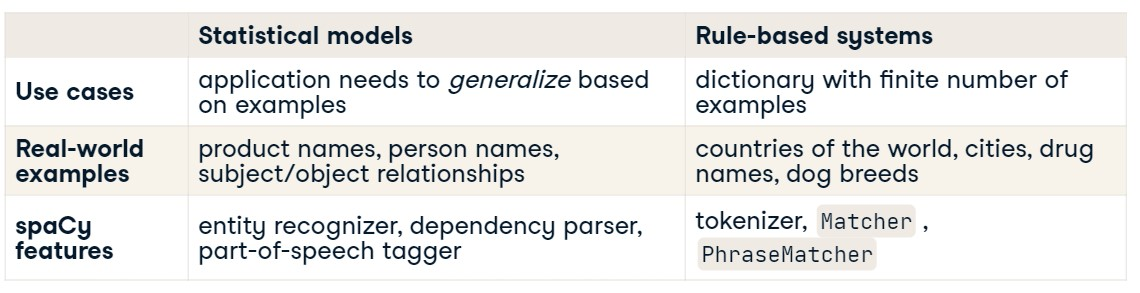

In [36]:
## Hình minh họa Image(fig1, height, width)

#### Recap: Rule-based Matching
In the [last chapter](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/NLP/Advanced%20NLP%20with%20Spacy/Finding%20words%2C%20phrases%2C%20names%20and%20concepts.ipynb), you learned how to use `spaCy's rule`-based matcher to find complex patterns in your texts. Here's a quick recap. The matcher is initialized with the shared vocabulary – usually `nlp.vocab`. 

- `Patterns` are lists of dictionaries, and each `dictionary` describes one token and its `attributes`. Patterns can be added to the matcher using the matcher dot add method. 
- `Operators` let you specify how often to match a `token`. 

For example, `"+"` will match one or more times. Calling the matcher on a doc object will return a list of the matches. Each match is a tuple consisting of an ID, and the start and end token index in the document.

In [37]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# Patterns are list of dictionaries describing the tokens
pattern = [{'LEMMA': 'love', 'POS': 'VERB'}, {'LOWER': 'cats'}]
matcher.add('LOVE_CATS', None, pattern)

# Operators can specify how often a token should be matched
pattern = [{'TEXT': 'very', 'OP': '+'}, {'TEXT': 'happy'}]

# Calling matcher on doc returns list of (match_id, start, end) tupples
doc = nlp("I love cat and I am very happy")
matches = matcher(doc)

#### Adding statistical predictions
Here's an example of a matcher rule for "golden retriever". 

If we iterate over the matches returned by the matcher, we can get the match ID and the start and end index of the matched span. We can then find out more about it. Span objects give us access to the original document and all other token attributes and linguistic features predicted by the model. 

- For example, we can get the span's root token. If the span consists of more than one token, this will be the token that decides the category of the phrase. 

In [38]:
matcher = Matcher(nlp.vocab)

matcher.add('DOG', None, [{'LOWER': 'golden'}, {'LOWER': 'retriever'}])
doc = nlp("I have a Golden Retriever")

for match_id, start, end in matcher(doc):
    span = doc[start: end]
    print('Matched span: \t\t', span.text)
    
    # Get span's root token and span root head token
    print('Root token: \t\t', span.root.text)
    print('Root head token: \t', span.root.head.text)
    
    # Get previous token and its POS_tag
    print("Previous token : \t", doc[start - 1].text)
    print("(Previous) POS_tag : \t", doc[start - 1].pos_)    

Matched span: 		 Golden Retriever
Root token: 		 Retriever
Root head token: 	 have
Previous token : 	 a
(Previous) POS_tag : 	 DET


- For example, the root of `"Golden Retriever"` is `"Retriever"`. 

We can also find the head token of the root. This is the syntactic `"parent"` that governs the phrase – in this case, the verb `"have"`. 

Finally, we can look at the previous token and its attributes. In this case, it's a determiner, the article `"a"`.

#### Efficient phrase matching
The `phrase matcher` is another helpful tool to find sequences of words in your data. It performs a keyword search on the document, but instead of only finding strings, it gives you **direct access to the tokens in context**. 

- It takes `Doc` objects as patterns.
- It's also really fast. 
- This makes it very useful for **matching large dictionaries and word lists** on large volumes of text.

Here's an example.

In [39]:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)

pattern = nlp("Golden Retriever")
matcher.add("DOG", None, pattern)

doc = nlp("I have a Golden Retriever")

for match_id, start, end in matcher(doc):
    span = doc[start : end]
    print('Matched span', span.text)

Matched span Golden Retriever


The `phrase matcher` can be imported from `spacy.matcher` and follows the same `API` as the regular matcher.

Instead of a list of dictionaries, we pass in a `Doc` object as the `pattern`. 

We can then iterate over the matches in the text, which gives us the match `ID`, and the start and end of the match. 

This lets us create a Span object for the matched tokens `"Golden Retriever"` to analyze it in context.

### 4.2. PRACTICES
#### Exercise 4.2.1. Debugging patterns (Part.1)
Why does this pattern not match the tokens `"Silicon Valley"` in the doc?

In [40]:
pattern = [{'LOWER': 'silicon'}, {'TEXT': ' '}, {'LOWER': 'valley'}]
doc = nlp("Can Silicon Valley workers rein in big tech from within?")

#### Answers.
The tokenizer doesn't create tokens for `single spaces`, so there's no token with the value `' '` in between.
#### Comments.
The tokenizer already takes care of splitting off whitespace and each dictionary in the pattern describes one token.

#### Exercise 4.2.2. Debugging patterns (Part.2)
Both patterns in this exercise contain mistakes and won't match as expected. 

        # Create the match patterns
        pattern1 = [{'LOWER': 'Amazon'}, {'IS_TITLE': True, 'POS': 'PROPN'}]
        pattern2 = [{'LOWER': 'ad-free'}, {'POS': 'NOUN'}]

        # Initialize the Matcher and add the patterns
        matcher = Matcher(nlp.vocab)
        matcher.add('PATTERN1', None, pattern1)
        matcher.add('PATTERN2', None, pattern2)

        # Iterate over the matches
        for match_id, start, end in matcher(doc):
            # Print pattern string name and text of matched span
            print(doc.vocab.strings[match_id], doc[start:end].text)

Can you fix them?

In [41]:
doc = nlp("Twitch Prime, the perks program for Amazon Prime members offering free loot, games and other benefits, is ditching one of its best features: ad-free viewing. According to an email sent out to Amazon Prime members today, ad-free viewing will no longer be included as a part of Twitch Prime for new members, beginning on September 14. However, members with existing annual subscriptions will be able to continue to enjoy ad-free viewing until their subscription comes up for renewal. Those with monthly subscriptions will have access to ad-free viewing until October 15.")

The `nlp` and a `doc` have already been created for you. 

#### SOLUTION

In [42]:
# Create the match patterns
pattern1 = [{'LOWER': 'amazon'}, {'IS_TITLE': True, 'POS': 'PROPN'}]
pattern2 = [{'LOWER': 'ad'}, {'TEXT': '-'}, {'LOWER': 'free'}, {'POS': 'NOUN'}]

# Initialize the Matcher and add the patterns
matcher = Matcher(nlp.vocab)
matcher.add('PATTERN1', None, pattern1)
matcher.add('PATTERN2', None, pattern2)

# Iterate over the matches
for match_id, start, end in matcher(doc):
    # Print pattern string name and text of matched span
    print(doc.vocab.strings[match_id], doc[start:end].text)

PATTERN1 Amazon Prime
PATTERN2 ad-free viewing
PATTERN1 Amazon Prime
PATTERN2 ad-free viewing
PATTERN2 ad-free viewing
PATTERN2 ad-free viewing


#### Comments
For the token `'_'`, you can match on the attribute `TEXT`, `LOWER` or even `SHAPE`. 

All of those are correct. As you can see, paying close attention to the tokenization is very important when working with the token-based Matcher. 

Sometimes it's much easier to just match exact strings instead and use the PhraseMatcher, which we'll get to in the next exercise.

#### Exercise 4.2.3. Efficient phrase matching
Sometimes it's more efficient to match exact strings instead of writing patterns describing the individual tokens. This is especially true for finite categories of things – like all countries of the world.

We already have a list of countries, so let's use this as the basis of our information extraction script. 

A list of string names is available as the variable `COUNTRIES`. 

In [43]:
doc = nlp("Czech Republic may help Slovakia protect its airspace")
COUNTRIES = ['Afghanistan', 'Åland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'United States Minor Outlying Islands', 'Virgin Islands (British)', 'Virgin Islands (U.S.)', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cabo Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic of the)', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', "Côte d'Ivoire", 'Iran (Islamic Republic of)', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia (the former Yugoslav Republic of)', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia (Federated States of)', 'Moldova (Republic of)', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', "Korea (Democratic People's Republic of)", 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestine, State of', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Republic of Kosovo', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Korea (Republic of)', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom of Great Britain and Northern Ireland', 'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Wallis and Futuna', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe']

The `nlp` object and a test `doc` have already been created and the doc.text has been printed to the shell.
#### SOLUTION

In [44]:
# Import the PhraseMatcher and initialize it
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)

# Create pattern Doc objects and add them to the matcher
# This is the faster version of: [nlp(country) for country in COUNTRIES]
patterns = list(nlp.pipe(COUNTRIES))
matcher.add('COUNTRY', None, *patterns)

# Call the matcher on the test document and print the result
matches = matcher(doc)
print([doc[start:end] for match_id, start, end in matches])

[Czech Republic, Slovakia]
